# Restaurant Recommendation System

## Introduction
Recommedation Systems are ubiquitous. They help you decide where to eat (zomato), what to buy (amazon), whom to marry(matrimony), what to listen(spotify). In this project we'll build a Restaurant Recommendation System using Collaborative Filtering from scratch. We have been given [Yelp Dataset](https://www.yelp.com/dataset) which has information of various users and their reviews to various businesses. Our model would learn from this information and would recommend new options to our users.

## Motivation
Due to the sheer amount of information available on the internet users feel overwhelmed with number of options available. To deal with this problem websites have Recommendation Systems, which simplifies decision making on user's part by showing options user might like based on his purchase history. Recommedation Systems play a very important role in websites like Youtube, Amazon, Spotify most of their revenue is driven by it.

## Team

This is final project for ML1. Team members include:

- Iniyan Nagaraju
- Jameel Khan
- Yashraj Wani
- Aziza 
- Akshay Kumar
- Gunakar Goswami

## Project Structure
This project is divided in three jupyter notebooks.
1. Getting Data Ready
2. Exploratory Data Analysis (EDA)
3. Modelling

## 1. Getting Data Ready
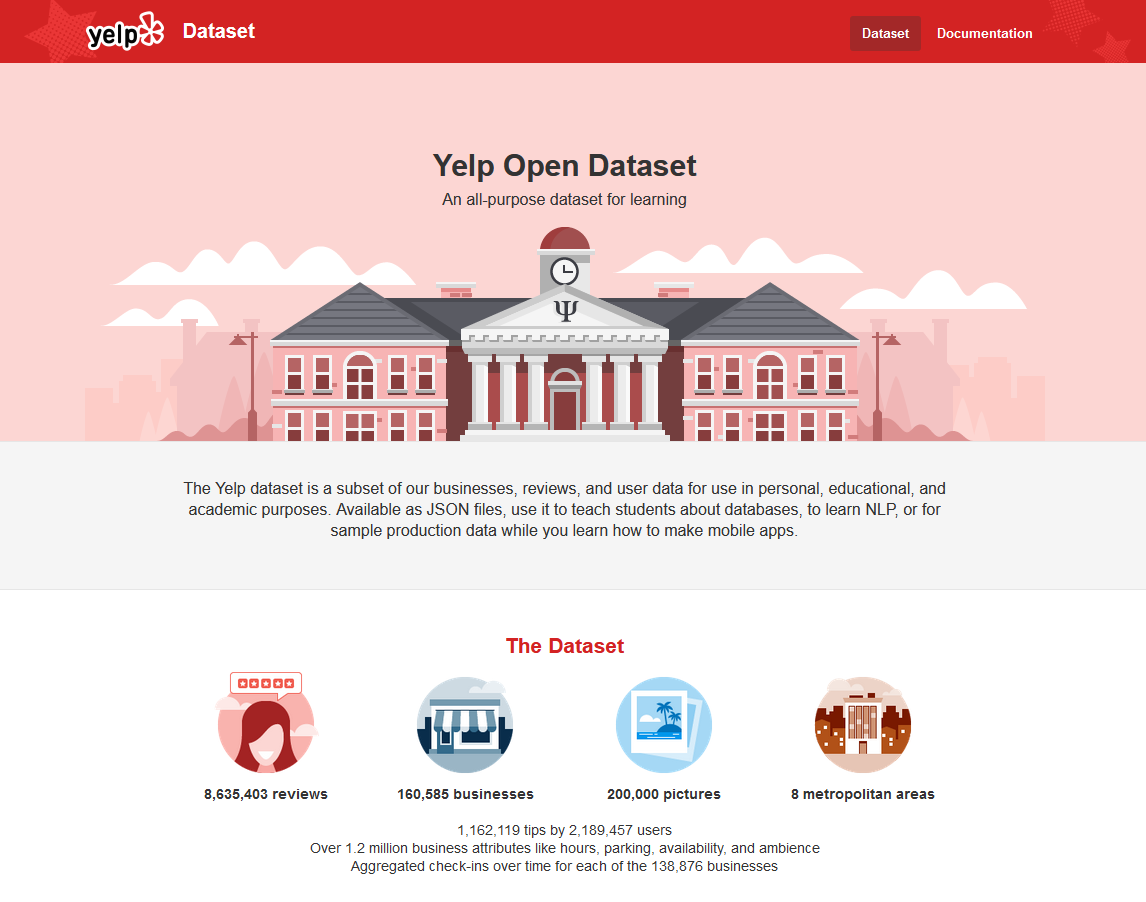

## Aim
We have been given [Yelp Dataset](https://www.yelp.com/dataset). In this notebook we'll go through data given to us, clean it and, save it so that we can use it for further steps. 

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json
from sqlite3 import dbapi2 as sq3
from pathlib import Path
from collections import OrderedDict

# import tensorflow as tf
# from tensorflow import keras

from time import time
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

### Loading Data

In [2]:
#Dataset Doc: https://www.yelp.com/dataset/documentation/main
#Data Paths
REVIEW_PATH = 'yelp_dataset/yelp_academic_dataset_review.json'      #Contains full review text data including the user_id that wrote the review and the business_id the review is written for.
CHECKIN_PATH = 'yelp_dataset/yelp_academic_dataset_checkin.json'    #Checkins on a business.
BUSINESS_PATH = 'yelp_dataset/yelp_academic_dataset_business.json'  #Contains business data including location data, attributes, and categories.
TIP_PATH = 'yelp_dataset/yelp_academic_dataset_tip.json'            #Tips written by a user on a business. Tips are shorter than reviews and tend to convey quick suggestions.
USER_PATH = 'yelp_dataset/yelp_academic_dataset_user.json'          #User data including the user's friend mapping and all the metadata associated with the user.

# Functions to load data from json format
#ref: https://www.kaggle.com/hexianwang/yelp-data
def load_rows(file_path, nrows=None, only_return_count=False, verbose=True):
    """
    Returns dataframe from json file
    """
    tic = time()
    with open(file_path, encoding='utf8') as json_file:
        count = 0
        objs = []
        line = json_file.readline()
        while (nrows is None or count<nrows) and line:
            count += 1
            if not only_return_count:
                obj = json.loads(line)
                objs.append(obj)
            line = json_file.readline()
        toc = time()
        if verbose:
            print(file_path.split('/')[-1], 'loaded. Count =', count, ', Time =', round(toc-tic,2), 'secs.')
        
        if only_return_count:
            return count
        
        return pd.DataFrame(objs)
    
    
#data generator to load data in chunks
def load_rows_gen(file_path, nrows=1e6, verbose=True):
    """
    Returns data in chunks
    """
    with open(file_path, encoding='utf8') as json_file:
        line = json_file.readline()
        total = 0
        while line:
            count = 0
            objs = []
            tic = time()
            while count<nrows and line:
                count+=1
                obj = json.loads(line)
                objs.append(obj)
                line = json_file.readline()
                total += count
            toc = time()
            print('Loaded chunk of size:', count, ", Time =", round(toc-tic,2), 'secs.')
            yield pd.DataFrame(objs)

### Looking at data

In [3]:
user_df_head = load_rows(USER_PATH, 5)
user_df_head

yelp_academic_dataset_user.json loaded. Count = 5 , Time = 0.15 secs.


user_id    name  review_count        yelping_since  useful  \
0  qVc8ODYU5SZjKXVBgXdI7w  Walker           585  2007-01-25 16:47:26    7217   
1  j14WgRoU_-2ZE1aw1dXrJg  Daniel          4333  2009-01-25 04:35:42   43091   
2  2WnXYQFK0hXEoTxPtV2zvg   Steph           665  2008-07-25 10:41:00    2086   
3  SZDeASXq7o05mMNLshsdIA    Gwen           224  2005-11-29 04:38:33     512   
4  hA5lMy-EnncsH4JoR-hFGQ   Karen            79  2007-01-05 19:40:59      29   

   funny   cool                                              elite  \
0   1259   5994                                               2007   
1  13066  27281  2009,2010,2011,2012,2013,2014,2015,2016,2017,2...   
2   1010   1003                           2009,2010,2011,2012,2013   
3    330    299                                     2009,2010,2011   
4     15      7                                                      

                                             friends  fans  ...  \
0  NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...   267  ...   
1  ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...  3138  ...   
2  LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...    52  ...   
3  enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...    28  ...   
4  PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...     1  ...   

   compliment_more  compliment_profile  compliment_cute  compliment_list  \
0               65                  55               56               18   
1              264                 184              157              251   
2               13                  10               17                3   
3                4                   1                6                2   
4                1                   0                0                0   

   compliment_note  compliment_plain  compliment_cool  compliment_funny  \
0              232               844              467               467   
1             1847              7054             3131              3131   
2               66                96              119               119   
3               12                16               26                26   
4                1                 1                0                 0   

   compliment_writer  compliment_photos  
0                239                180  
1               1521               1946  
2                 35                 18  
3                 10                  9  
4                  0                  0  

[5 rows x 22 columns]

In [4]:
review_df_head = load_rows(REVIEW_PATH, 5)
review_df_head

yelp_academic_dataset_review.json loaded. Count = 5 , Time = 0.03 secs.


review_id                 user_id             business_id  \
0  KU_O5udG6zpxOg-VcAEodg  mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   
1  BiTunyQ73aT9WBnpR9DZGw  OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   
2  saUsX_uimxRlCVr67Z4Jig  8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   
3  AqPFMleE6RsU23_auESxiA  _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   
4  Sx8TMOWLNuJBWer-0pcmoA  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   

   stars  useful  funny  cool  \
0    3.0       0      0     0   
1    5.0       1      0     1   
2    3.0       0      0     0   
3    5.0       1      0     1   
4    4.0       1      0     1   

                                                text                 date  
0  If you decide to eat here, just be aware it is...  2018-07-07 22:09:11  
1  I've taken a lot of spin classes over the year...  2012-01-03 15:28:18  
2  Family diner. Had the buffet. Eclectic assortm...  2014-02-05 20:30:30  
3  Wow!  Yummy, different,  delicious.   Our favo...  2015-01-04 00:01:03  
4  Cute interior and owner (?) gave us tour of up...  2017-01-14 20:54:15

In [5]:
business_df_head = load_rows(BUSINESS_PATH, 5)
business_df_head.head()

yelp_academic_dataset_business.json loaded. Count = 5 , Time = 0.02 secs.


business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2  tUFrWirKiKi_TAnsVWINQQ                    Target   
3  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1  87 Grasso Plaza Shopping Center         Affton    MO       63123   
2             5255 E Broadway Blvd         Tucson    AZ       85711   
3                      935 Race St   Philadelphia    PA       19107   
4                    101 Walnut St     Green Lane    PA       18054   

    latitude   longitude  stars  review_count  is_open  \
0  34.426679 -119.711197    5.0             7        0   
1  38.551126  -90.335695    3.0            15        1   
2  32.223236 -110.880452    3.5            22        0   
3  39.955505  -75.155564    4.0            80        1   
4  40.338183  -75.471659    4.5            13        1   

                                          attributes  \
0                      {'ByAppointmentOnly': 'True'}   
1             {'BusinessAcceptsCreditCards': 'True'}   
2  {'BikeParking': 'True', 'BusinessAcceptsCredit...   
3  {'RestaurantsDelivery': 'False', 'OutdoorSeati...   
4  {'BusinessAcceptsCreditCards': 'True', 'Wheelc...   

                                          categories  \
0  Doctors, Traditional Chinese Medicine, Naturop...   
1  Shipping Centers, Local Services, Notaries, Ma...   
2  Department Stores, Shopping, Fashion, Home & G...   
3  Restaurants, Food, Bubble Tea, Coffee & Tea, B...   
4                          Brewpubs, Breweries, Food   

                                               hours  
0                                               None  
1  {'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...  
2  {'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...  
3  {'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...  
4  {'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...

In [6]:
checkin_df_head = load_rows(CHECKIN_PATH, 5)
checkin_df_head

yelp_academic_dataset_checkin.json loaded. Count = 5 , Time = 0.04 secs.


business_id                                               date
0  ---kPU91CF4Lq2-WlRu9Lw  2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020...
1  --0iUa4sNDFiZFrAdIWhZQ  2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011...
2  --30_8IhuyMHbSOcNWd6DQ           2013-06-14 23:29:17, 2014-08-13 23:20:22
3  --7PUidqRWpRSpXebiyxTg  2011-02-15 17:12:00, 2011-07-28 02:46:10, 2012...
4  --7jw19RH9JKXgFohspgQw  2014-04-21 20:42:11, 2014-04-28 21:04:46, 2014...

In [7]:
tip_df_head = load_rows(TIP_PATH, 5)
tip_df_head

yelp_academic_dataset_tip.json loaded. Count = 5 , Time = 0.02 secs.


user_id             business_id  \
0  AGNUgVwnZUey3gcPCJ76iw  3uLgwr0qeCNMjKenHJwPGQ   
1  NBN4MgHP9D3cw--SnauTkA  QoezRbYQncpRqyrLH6Iqjg   
2  -copOvldyKh1qr-vzkDEvw  MYoRNLb5chwjQe3c_k37Gg   
3  FjMQVZjSqY8syIO-53KFKw  hV-bABTK-glh5wj31ps_Jw   
4  ld0AperBXk1h6UbqmM80zw  _uN0OudeJ3Zl_tf6nxg5ww   

                                                text                 date  \
0                     Avengers time with the ladies.  2012-05-18 02:17:21   
1  They have lots of good deserts and tasty cuban...  2013-02-05 18:35:10   
2             It's open even when you think it isn't  2013-08-18 00:56:08   
3                          Very decent fried chicken  2017-06-27 23:05:38   
4             Appetizers.. platter special for lunch  2012-10-06 19:43:09   

   compliment_count  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

We'll be using User (details abouts user), Business (Details about business), and Review (users and their reviews for business) data.

### Create SQLite database
As data size is more than what our RAM can handle.

In [8]:
# Functions to work with db2api from sqlite3

PATHSTART = "."
def get_db(dbfile):
    #get connection to db
    sqlite_db = sq3.connect(Path(PATHSTART)/ dbfile)
    return sqlite_db

def init_db(dbfile, schema):
    #create db a/c to schema
    db = get_db(dbfile)
    
    #execute sql code
    c = db.cursor()
    c.executescript(schema)
    
    #make commit
    db.commit()
    return db

def make_query(sel):
    c = db.cursor().execute(sel)
    return c.fetchall()

from collections import OrderedDict
def make_frame(list_of_tuples, legend):
    framelist=[]
    for i, cname in enumerate(legend):
        framelist.append((cname,[e[i] for e in list_of_tuples]))
    return pd.DataFrame.from_dict(OrderedDict(framelist)) 

In [9]:
#Table Schema for tables in our SQLite database

users_schema = """
DROP TABLE IF EXISTS "users";

CREATE TABLE "users" (
    "user_id" INTEGER PRIMARY KEY NOT NULL,
    "name" VARCHAR,
    "review_count" INTEGER,
    "yelping_since" TIMESTAMP,
    "useful" INTEGER,
    "funny" INTEGER,
    "cool" INTEGER,
    "elite" VARCHAR,
    "friends" VARCHAR,
    "fans" INTEGER,
    "average_stars" FLOAT,
    "compliment_hot" INTEGER,
    "compliment_more" INTEGER, 
    "compliment_profile" INTEGER,
    "compliment_cute" INTEGER,
    "compliment_list" INTEGER,
    "compliment_note" INTEGER,
    "compliment_plain" INTEGER,
    "compliment_cool" INTEGER,
    "compliment_funny" INTEGER,
    "compliment_writer" INTEGER,
    "compliment_photos" INTEGER
);
"""
businesses_schema="""
DROP TABLE IF EXISTS "businesses";

CREATE TABLE "businesses" (
    "business_id" INTEGER PRIMARY KEY NOT NULL,
    "name" VARCHAR,
    "address" VARCHAR,
    "city" VARCHAR,
    "state" VARCHAR,
    "postal_code" VARCHAR,
    "latitude" FLOAT,
    "longitude" FLOAT,
    "stars" FLOAT,
    "review_count" INTEGER,
    "is_open" BOOLEAN,
    "categories" VARCHAR,
"""
reviews_schema = """
DROP TABLE IF EXISTS "reviews";

CREATE TABLE "reviews" (
    "review_id" VARCHAR PRIMARY KEY,
    "user_id" INTEGER,
    "business_id" INTEGER,
    "stars" FLOAT,
    "useful" INTEGER,
    "funny" INTEGER,
    "cool" INTEGER,
    "text"  VARCHAR,
    "date" TIMESTAMP,
    
    
    FOREIGN KEY (user_id) REFERENCES users(user_id),
    FOREIGN KEY (business_id) REFERENCES businesses(business_id)
);
"""
schema_close = ");"

In [10]:
#Load data about all businesses
business_df = load_rows(BUSINESS_PATH)
business_df.head()

yelp_academic_dataset_business.json loaded. Count = 150346 , Time = 3.47 secs.


business_id                      name  \
0  Pns2l4eNsfO8kk83dixA6A  Abby Rappoport, LAC, CMQ   
1  mpf3x-BjTdTEA3yCZrAYPw             The UPS Store   
2  tUFrWirKiKi_TAnsVWINQQ                    Target   
3  MTSW4McQd7CbVtyjqoe9mw        St Honore Pastries   
4  mWMc6_wTdE0EUBKIGXDVfA  Perkiomen Valley Brewery   

                           address           city state postal_code  \
0           1616 Chapala St, Ste 2  Santa Barbara    CA       93101   
1  87 Grasso Plaza Shopping Center         Affton    MO       63123   
2             5255 E Broadway Blvd         Tucson    AZ       85711   
3                      935 Race St   Philadelphia    PA       19107   
4                    101 Walnut St     Green Lane    PA       18054   

    latitude   longitude  stars  review_count  is_open  \
0  34.426679 -119.711197    5.0             7        0   
1  38.551126  -90.335695    3.0            15        1   
2  32.223236 -110.880452    3.5            22        0   
3  39.955505  -75.155564    4.0            80        1   
4  40.338183  -75.471659    4.5            13        1   

                                          attributes  \
0                      {'ByAppointmentOnly': 'True'}   
1             {'BusinessAcceptsCreditCards': 'True'}   
2  {'BikeParking': 'True', 'BusinessAcceptsCredit...   
3  {'RestaurantsDelivery': 'False', 'OutdoorSeati...   
4  {'BusinessAcceptsCreditCards': 'True', 'Wheelc...   

                                          categories  \
0  Doctors, Traditional Chinese Medicine, Naturop...   
1  Shipping Centers, Local Services, Notaries, Ma...   
2  Department Stores, Shopping, Fashion, Home & G...   
3  Restaurants, Food, Bubble Tea, Coffee & Tea, B...   
4                          Brewpubs, Breweries, Food   

                                               hours  
0                                               None  
1  {'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...  
2  {'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ...  
3  {'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...  
4  {'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...

In [11]:
%%time

#Here we preprocess our businesses data
def preprocess_business_df(df):
    """
    Preprocess data from BUSINESS_PATH
    returns final DataFrame
    """
    #mask to only select businesses which are either Restaurant or serve Food
    mask = df.categories.str.contains('Restaurant', na=False) | df.categories.str.contains('Food', na=False)
    df = df[mask]
    #Changing business_id to numbers
    global businessid_to_idx
    businessid_to_idx = {b_id : idx for idx, b_id in enumerate(df.business_id.unique())}
    df.business_id = df.business_id.map(lambda x: businessid_to_idx[x])

    #TDT
    df.is_open = df.is_open.astype(bool)

    # Exploding attributes [MultiCategorization]
    attr = [col for col in df.attributes.explode().unique() if col is not None]
    lst_of_attr_dict = []
    for attr_dict in df.attributes:
        if not attr_dict:
            lst_of_attr_dict.append({})
            continue

        if 'BusinessParking' in attr_dict:
            if type(attr_dict['BusinessParking']) == str:
                attr_dict['BusinessParking'] = ('True' in attr_dict['BusinessParking'])

        lst_of_attr_dict.append(attr_dict)
    
    attr_df = pd.DataFrame(lst_of_attr_dict, columns=attr)
    for col in attr_df:
        #Handling missing
        #Strategy -> absence of attribute means restauratn doesn't have it
        #ex. If parking is null then restaurant doesn't have parking
        attr_df[col] = attr_df[col].fillna(False).astype(bool)
    
    df = pd.concat([df.reset_index().drop('index', axis=1), attr_df], axis=1)
    df.drop(['attributes'], axis=1, inplace=True)
    
    #Exploding hours ie. getting opening and closing time for various days
    lst_of_time = []
    for time_dict in df.hours:
        if not time_dict:
            lst_of_time.append({})
            continue
        lst_of_time.append(time_dict)
    time_df = pd.DataFrame(lst_of_time)
    df = pd.concat([df, time_df], axis=1).drop('hours', axis=1)
    
    return df

business_df = preprocess_business_df(business_df)
business_df.head()

CPU times: user 1.99 s, sys: 49.6 ms, total: 2.04 s
Wall time: 2.04 s


business_id                      name              address          city  \
0            0        St Honore Pastries          935 Race St  Philadelphia   
1            1  Perkiomen Valley Brewery        101 Walnut St    Green Lane   
2            2            Sonic Drive-In        615 S Main St  Ashland City   
3            3     Tsevi's Pub And Grill    8025 Mackenzie Rd        Affton   
4            4            Sonic Drive-In  2312 Dickerson Pike     Nashville   

  state postal_code   latitude  longitude  stars  review_count  ...  \
0    PA       19107  39.955505 -75.155564    4.0            80  ...   
1    PA       18054  40.338183 -75.471659    4.5            13  ...   
2    TN       37015  36.269593 -87.058943    2.0             6  ...   
3    MO       63123  38.565165 -90.321087    3.0            19  ...   
4    TN       37207  36.208102 -86.768170    1.5            10  ...   

   AgesAllowed DietaryRestrictions  HairSpecializesIn    Monday   Tuesday  \
0        False               False              False  7:0-20:0  7:0-20:0   
1        False               False              False       NaN       NaN   
2        False               False              False   0:0-0:0  6:0-22:0   
3        False               False              False       NaN       NaN   
4        False               False              False   0:0-0:0  6:0-21:0   

   Wednesday   Thursday     Friday   Saturday     Sunday  
0   7:0-20:0   7:0-20:0   7:0-21:0   7:0-21:0   7:0-21:0  
1  14:0-22:0  16:0-22:0  12:0-22:0  12:0-22:0  12:0-18:0  
2   6:0-22:0   6:0-22:0    9:0-0:0   9:0-22:0   8:0-22:0  
3        NaN        NaN        NaN        NaN        NaN  
4   6:0-21:0   6:0-16:0   6:0-16:0   6:0-17:0   6:0-21:0  

[5 rows x 58 columns]

In [12]:
# Looking at overview of our data
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64629 entries, 0 to 64628
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   business_id                 64629 non-null  int64  
 1   name                        64629 non-null  object 
 2   address                     64629 non-null  object 
 3   city                        64629 non-null  object 
 4   state                       64629 non-null  object 
 5   postal_code                 64629 non-null  object 
 6   latitude                    64629 non-null  float64
 7   longitude                   64629 non-null  float64
 8   stars                       64629 non-null  float64
 9   review_count                64629 non-null  int64  
 10  is_open                     64629 non-null  bool   
 11  categories                  64629 non-null  object 
 12  RestaurantsDelivery         64629 non-null  bool   
 13  OutdoorSeating              646

In [13]:
# Completing Business Table Schema
for bool_col in business_df.columns[12:51]:
    businesses_schema += '    \"' + bool_col + '\"' + ' BOOLEAN,\n'
for day in business_df.columns[51:]:
    businesses_schema += '    \"' + day + '\"' + ' VARCHAR,\n'
    
businesses_schema = businesses_schema[:-2] + schema_close

In [14]:
%%time
#Create db
db = init_db("yelp_database.db", users_schema+businesses_schema+reviews_schema)

#business data to sql
business_df.to_sql('businesses', db, if_exists='append', index=False)

#release memory
del business_df

CPU times: user 2.12 s, sys: 85.9 ms, total: 2.21 s
Wall time: 3.47 s


In [15]:
#load data about users
user_df = load_rows(USER_PATH)
user_df.head()

yelp_academic_dataset_user.json loaded. Count = 1987897 , Time = 64.57 secs.


user_id    name  review_count        yelping_since  useful  \
0  qVc8ODYU5SZjKXVBgXdI7w  Walker           585  2007-01-25 16:47:26    7217   
1  j14WgRoU_-2ZE1aw1dXrJg  Daniel          4333  2009-01-25 04:35:42   43091   
2  2WnXYQFK0hXEoTxPtV2zvg   Steph           665  2008-07-25 10:41:00    2086   
3  SZDeASXq7o05mMNLshsdIA    Gwen           224  2005-11-29 04:38:33     512   
4  hA5lMy-EnncsH4JoR-hFGQ   Karen            79  2007-01-05 19:40:59      29   

   funny   cool                                              elite  \
0   1259   5994                                               2007   
1  13066  27281  2009,2010,2011,2012,2013,2014,2015,2016,2017,2...   
2   1010   1003                           2009,2010,2011,2012,2013   
3    330    299                                     2009,2010,2011   
4     15      7                                                      

                                             friends  fans  ...  \
0  NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...   267  ...   
1  ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...  3138  ...   
2  LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...    52  ...   
3  enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...    28  ...   
4  PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...     1  ...   

   compliment_more  compliment_profile  compliment_cute  compliment_list  \
0               65                  55               56               18   
1              264                 184              157              251   
2               13                  10               17                3   
3                4                   1                6                2   
4                1                   0                0                0   

   compliment_note  compliment_plain  compliment_cool  compliment_funny  \
0              232               844              467               467   
1             1847              7054             3131              3131   
2               66                96              119               119   
3               12                16               26                26   
4                1                 1                0                 0   

   compliment_writer  compliment_photos  
0                239                180  
1               1521               1946  
2                 35                 18  
3                 10                  9  
4                  0                  0  

[5 rows x 22 columns]

In [16]:
%%time
#Preproccess user data
def preprocess_user_df(df):
    #Changing user id to something more suitable for our analysis
    global userid_to_idx
    userid_to_idx = {user : idx for idx, user in enumerate(df.user_id.unique())}
    df.user_id = df.user_id.map(lambda x: userid_to_idx[x])
    #Changing friends ids to new int ids
    df.friends = df.friends.map(lambda x : str([userid_to_idx[user] for user in x.split(',') if user in userid_to_idx]))
    #TDT to datetime
    df.yelping_since = pd.to_datetime(df.yelping_since)
    df.elite = df.elite.replace('', np.nan)
    return df

user_df = preprocess_user_df(user_df)

CPU times: user 36.1 s, sys: 22.5 ms, total: 36.1 s
Wall time: 36.5 s


In [17]:
%%time
#Sending user data to SQL db
user_df.to_sql('users', db, if_exists='append', index=False)
#Release memory
del user_df

CPU times: user 16.9 s, sys: 622 ms, total: 17.5 s
Wall time: 19.1 s


In [18]:
%%time
#Here we load data from reviews

#size of review.json overpowers RAM hence we'll process data in chunks and store it to table
for data in load_rows_gen(REVIEW_PATH):
    #transformations
    data.user_id = data.user_id.apply(lambda key : userid_to_idx[key] if key in userid_to_idx else np.nan)
    data.business_id = data.business_id.apply(lambda key : businessid_to_idx[key] if key in businessid_to_idx else np.nan)
    data.date = pd.to_datetime(data.date)
    data.dropna(inplace=True)
    #sending chunk to sql
    data.to_sql('reviews', db, if_exists='append', index=False)
#del data

Loaded chunk of size: 1000000 , Time = 12.53 secs.
Loaded chunk of size: 1000000 , Time = 17.1 secs.
Loaded chunk of size: 1000000 , Time = 14.37 secs.
Loaded chunk of size: 1000000 , Time = 11.49 secs.
Loaded chunk of size: 1000000 , Time = 16.03 secs.
Loaded chunk of size: 1000000 , Time = 11.3 secs.
Loaded chunk of size: 990280 , Time = 11.35 secs.
CPU times: user 3min 11s, sys: 1min 27s, total: 4min 39s
Wall time: 18min 28s


In [19]:
#Looking at last chunk
data.head()

review_id    user_id  business_id  stars  useful  funny  cool  \
0  LEt_rcvZ9UsAhQCRGRBkVQ    55859.0      57066.0    4.0       1      1     0   
2  K4gdzC3ut1SJAkHWR_YGQQ   913166.0      57082.0    1.0       0      0     0   
3  7hGVG9nUzhpiiSAniPDTbg    51384.0      52530.0    3.0       2      0     2   
4  1z_2diaMLhSkc0z4L0BxnQ   415994.0      55602.0    2.0       3      0     0   
6  -pMqa4mXtbsT0VYePB5xHA  1489292.0      57703.0    5.0       1      0     0   

                                                text                date  
0  Very good food here!  Casual dining in the Don... 2017-05-12 23:58:29  
2  The bar 33 is nice but restaurant overrated, h... 2016-05-15 05:00:45  
3  The place is located inside the new China Town... 2017-04-06 23:17:53  
4  Ordered Chicken Fried Rice. Rice was not fried... 2018-11-27 02:18:43  
6  The desserts and dinner are spectacular!  Not ... 2019-04-28 02:50:57

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 715569 entries, 0 to 990279
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   review_id    715569 non-null  object        
 1   user_id      715569 non-null  float64       
 2   business_id  715569 non-null  float64       
 3   stars        715569 non-null  float64       
 4   useful       715569 non-null  int64         
 5   funny        715569 non-null  int64         
 6   cool         715569 non-null  int64         
 7   text         715569 non-null  object        
 8   date         715569 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 54.6+ MB


In [21]:
#Release memory
del data

## Conclusion
- We made a SQLite db from our data.
- Our db has 3 tables:
 - reviews (has review info)
 - users (has user info)
 - businesses (has business info)
- Made basic transformations like simple null handling, changing id, type casting.

#### Links

[2. Exploratory Data Analysis (EDA)](https://www.kaggle.com/yashrajwani/yelp-exploratory-data-analysis)

[3. Restaurant Recommendation](https://www.kaggle.com/yashrajwani/yelp-restaurant-recommendation-system)